<a href="https://colab.research.google.com/github/VIJAY7701/vue-work/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

print(tf.__version__)


2.12.0


In [4]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

Resize images

In [5]:
IMAGE_SIZE =[224,224]

In [6]:
df = pd.read_csv(r'/content/drive/MyDrive/gaussian/train.csv')

diagnosis_dict_binary = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

id_code  diagnosis  binary_type            type
0  000c1434d8d7          2            1        Moderate
1  001639a390f0          4            1  Proliferate_DR
2  0024cdab0c1e          1            1            Mild
3  002c21358ce6          0            0           No_DR
4  005b95c28852          0            0           No_DR

<Axes: >

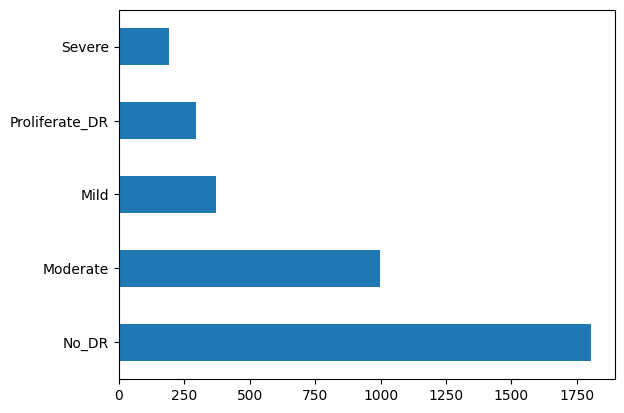

In [7]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

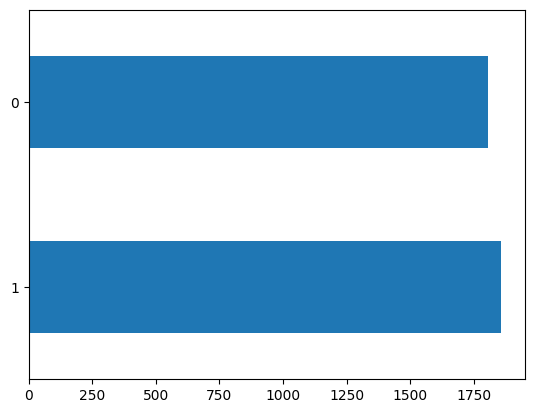

In [8]:
df['binary_type'].value_counts().plot(kind='barh')

In [9]:
sdir=r'/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images'
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)        
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
1  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
2  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
3  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
4  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
df length:  3665
No_DR             1805
Moderate          1002
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64


In [10]:
img1 = cv2.imread("/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images/Mild/0eb52045349f.png")
plt.imshow(img1)
plt.title("Mild")
plt.show()

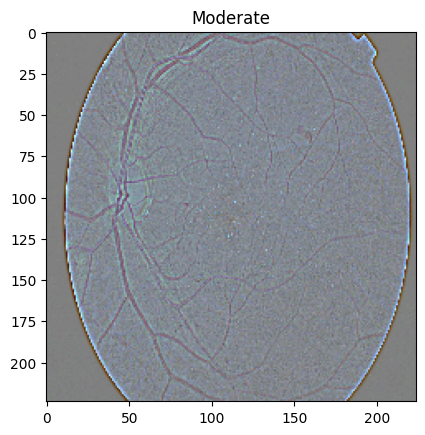

In [11]:
img1 = cv2.imread("/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images/Moderate/141735b57ec0.png")
plt.imshow(img1)
plt.title("Moderate")
plt.show()

In [12]:
img1 =cv2.imread("/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images/No_DR/01f7bb8be950.png")
plt.imshow(img1)
plt.title("No DR")
plt.show()

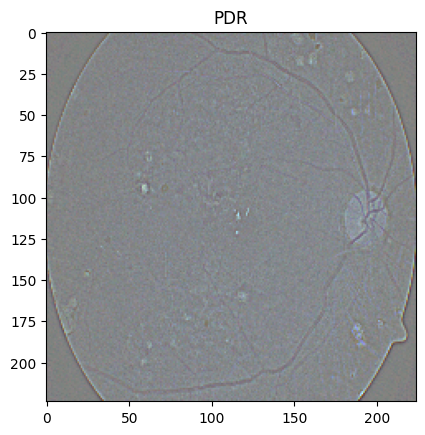

In [13]:
img1 =cv2.imread("/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0e82bcacc475.png")
plt.imshow(img1)
plt.title("PDR")
plt.show()

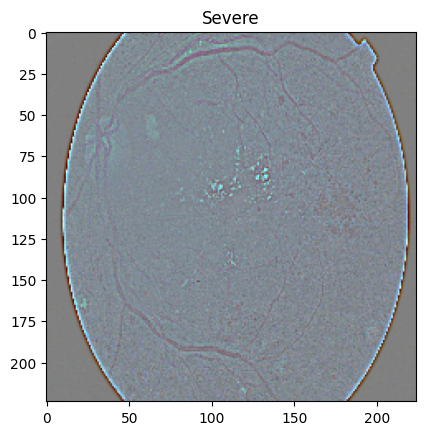

In [14]:

img1 = cv2.imread("/content/drive/MyDrive/gaussian/gaussian_filtered_images/gaussian_filtered_images/Severe/070f67572d03.png")
plt.imshow(img1)
plt.title("Severe")
plt.show()

Down sample class "No DR" from 1805 to 1500

In [15]:
sample_list=[]
max_size= 1500
groups=df.groupby('labels')
for label in df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))     
print (df['labels'].value_counts())

3360
No_DR             1500
Moderate          1002
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64


Creating a work Directory

In [16]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Proliferate_DR', 'Mild', 'Severe', 'No_DR', 'Moderate']


#Augmentation of Data

In [17]:

target=1500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 370 validated image filenames.
Found 193 validated image filenames.
Found 295 validated image filenames.
Found 1002 validated image filenames.


In [18]:
aug=r'./aug'
auglist=os.listdir(aug)
print (auglist)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('class: ', klass, '  file count: ', len(flist))

['Proliferate_DR', 'Mild', 'Severe', 'No_DR', 'Moderate']
class:  Proliferate_DR   file count:  1205
class:  Mild   file count:  1130
class:  Severe   file count:  1307
class:  No_DR   file count:  0
class:  Moderate   file count:  498


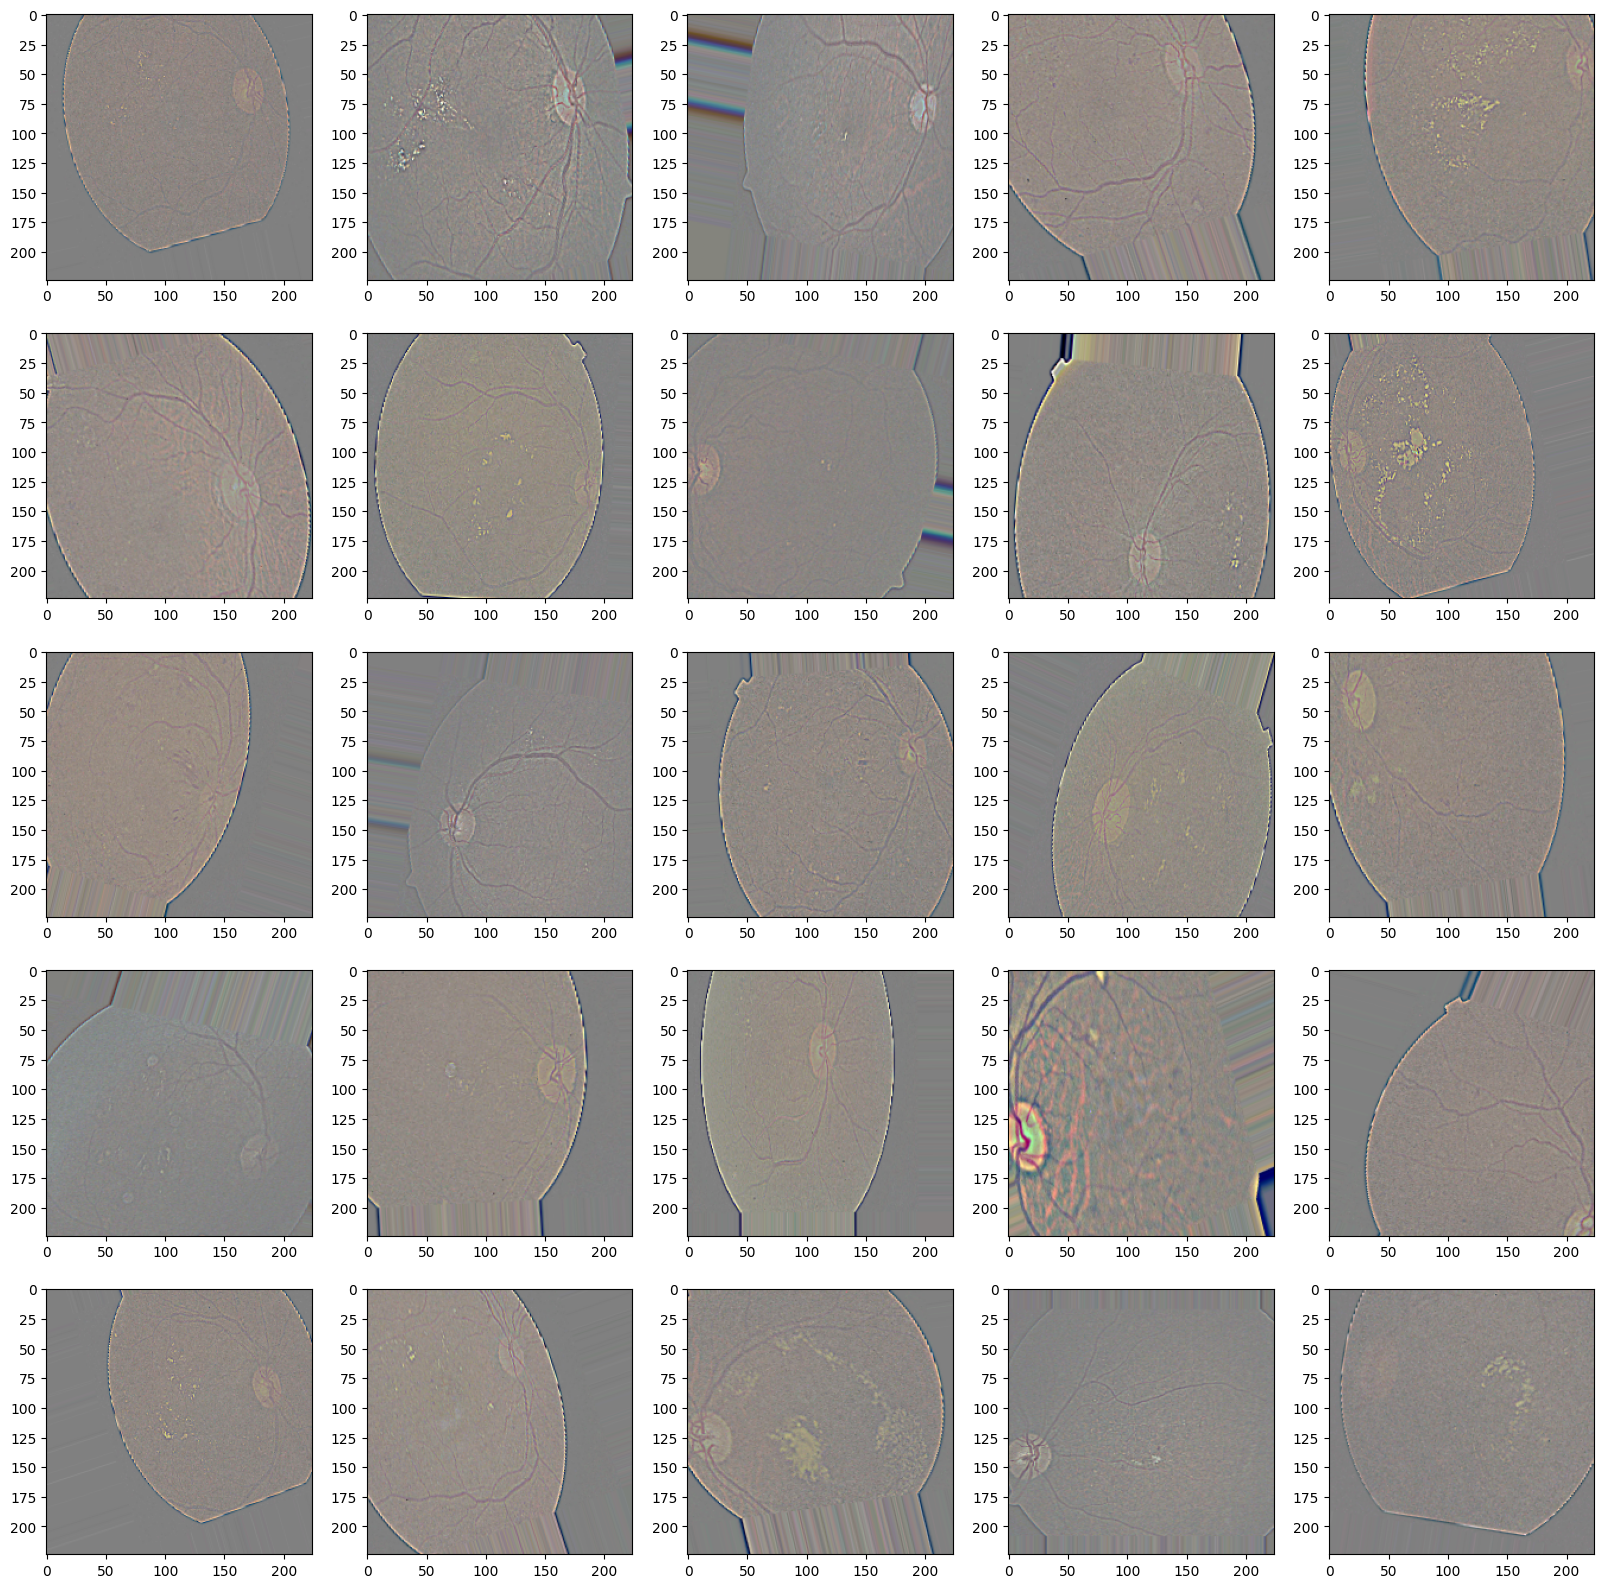

In [19]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image=next(aug_gen)/255
    image=np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()

In [20]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['labels'].value_counts()) 
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts()) 

No_DR             1500
Moderate          1002
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64
Severe            1307
Proliferate_DR    1205
Mild              1130
Moderate           523
Name: labels, dtype: int64
Moderate          1525
Mild              1500
No_DR             1500
Severe            1500
Proliferate_DR    1500
Name: labels, dtype: int64


In [21]:
ndf.head()

filepaths labels
0  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
1  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
2  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
3  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild
4  /content/drive/MyDrive/gaussian/gaussian_filte...   Mild

In [22]:
train_split=.8
valid_split=.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  6020   test_df length:  753   valid_df length:  752


Generators


In [23]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  3   test steps:  251
Found 6020 validated image filenames belonging to 5 classes.
Found 753 validated image filenames belonging to 5 classes.
Found 752 validated image filenames belonging to 5 classes.


In [24]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

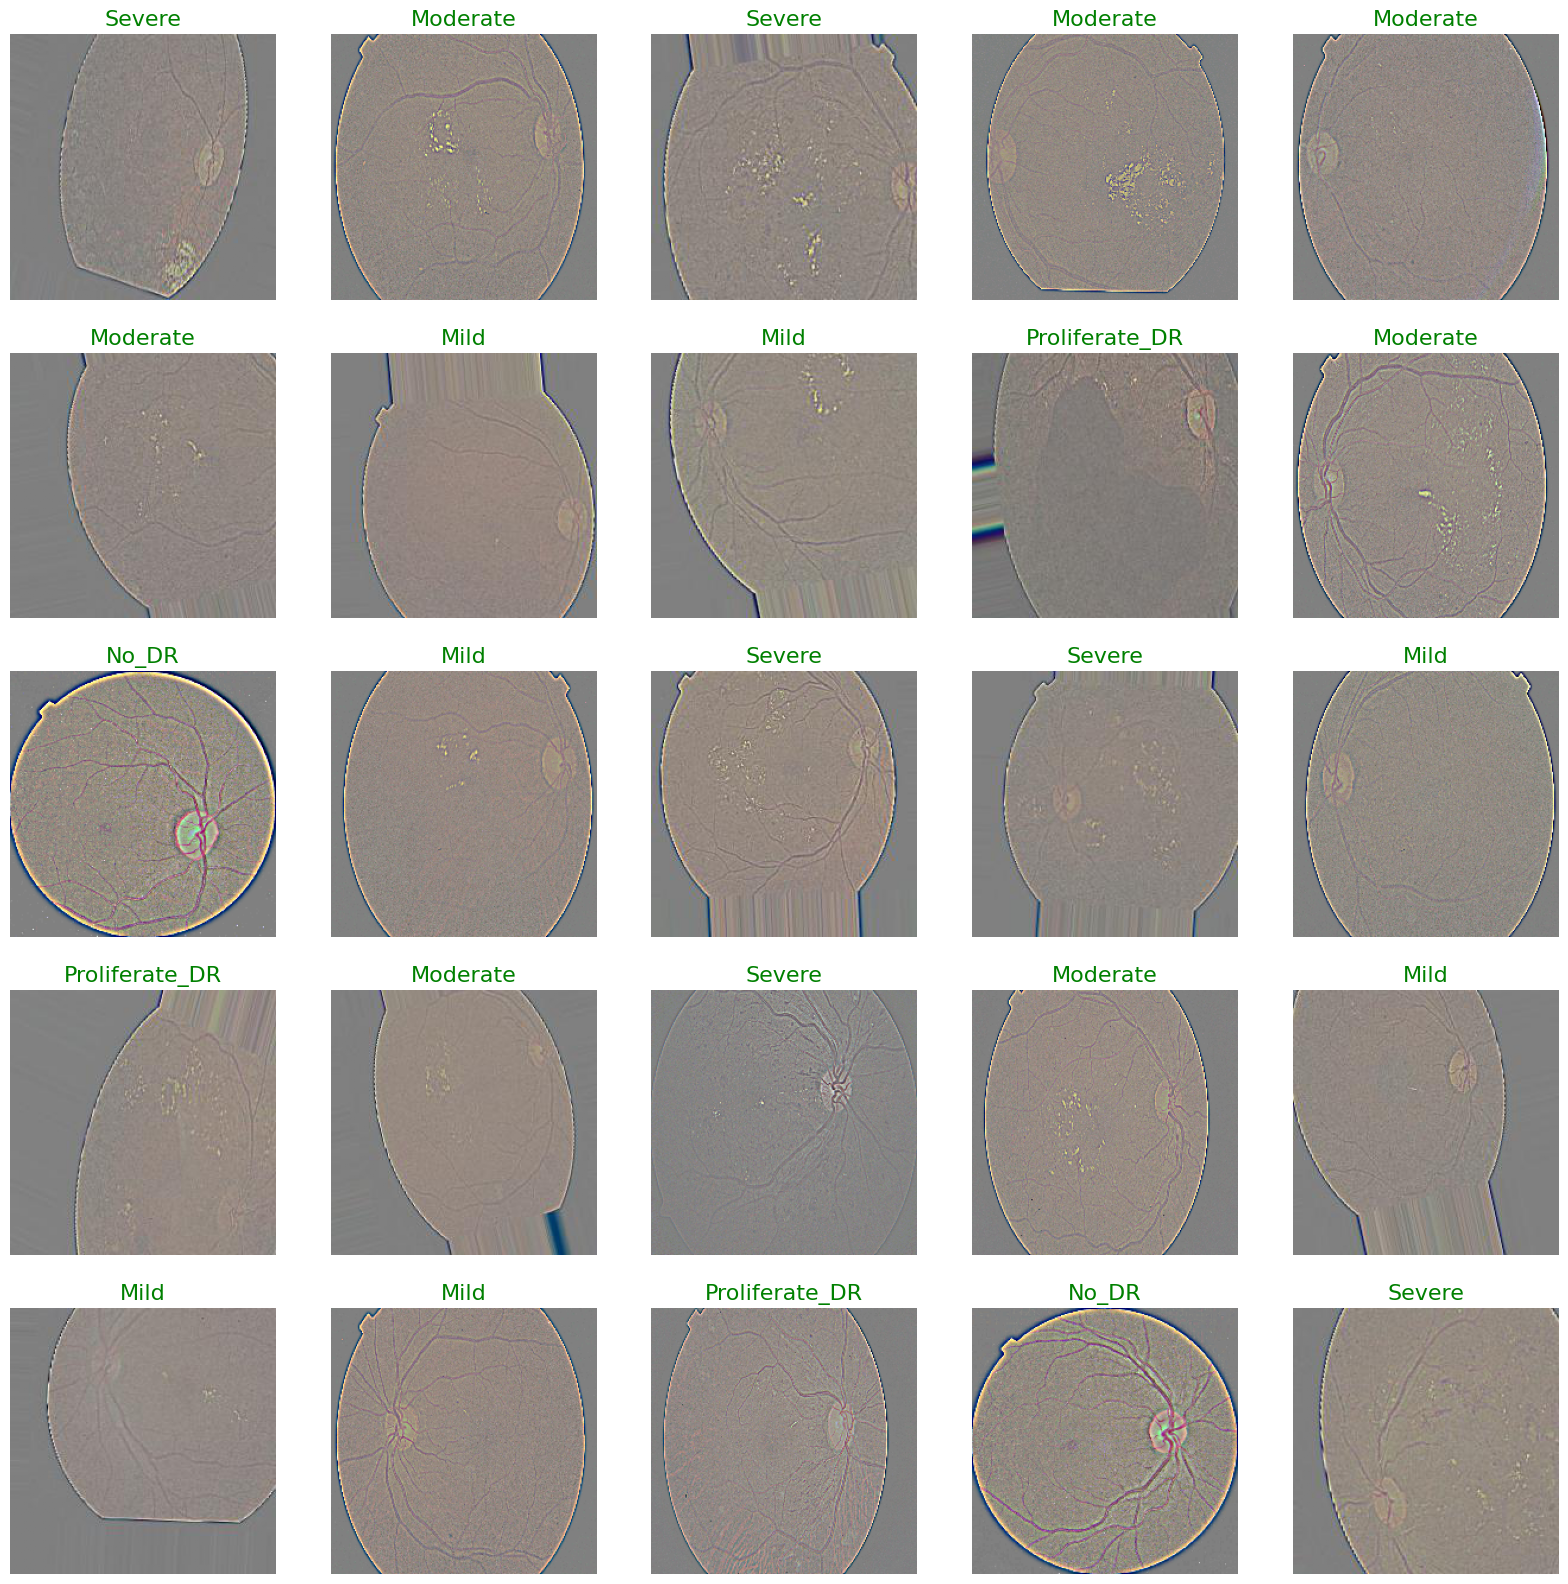

In [25]:
show_image_samples(train_gen)

In [26]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans

In [27]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

Operating Our Model"EfficientNetB1"

In [29]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [30]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     7.220   54.801   5.94723  58.378   0.00100  0.00100  accuracy   137.99 

 2 /40     4.908   66.296   4.14844  67.553   0.00100  0.00100  accuracy   70.49  

 3 /40     3.519   73.588   3.02235  72.872   0.00100  0.00100  accuracy   73.32  

 4 /40     2.512   78.538   2.27005  73.005   0.00100  0.00100  accuracy   70.58  

 5 /40     1.790   83.904   1.67767  79.122   0.00100  0.00100  accuracy   70.63  

 6 /40     1.287   88.056   1.36160  78.324   0.00100  0.00100  accuracy   70.60  

 7 /40     0.940   91.246   1.10283  79.521   0.00100  0.00100  val_loss   73.43  

 8 /40     0.723   93.389   0.97103  78.457   0.00100  0.00100  val_loss   70.59  

 9 /40     0.562   94.934   0.88144  79.787   0.00100  0.00100  val_loss   70.55  

10 /40     0.459   95.831   0.77798  81.782   0.00100  0.00100  val_loss   70.66  

ente

Building The Model

In [32]:
"""model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

history = model.fit(x=train_gen,
                    epochs=30,
                    validation_data=valid_gen)"""

'model = tf.keras.Sequential([\n    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = \'relu\'),\n    layers.MaxPooling2D(pool_size=(2,2)),\n    layers.BatchNormalization(),\n    \n    layers.Conv2D(16, (3,3), padding="valid", activation = \'relu\'),\n    layers.MaxPooling2D(pool_size=(2,2)),\n    layers.BatchNormalization(),\n    \n    layers.Conv2D(32, (4,4), padding="valid", activation = \'relu\'),\n    layers.MaxPooling2D(pool_size=(2,2)),\n    layers.BatchNormalization(),\n \n    layers.Flatten(),\n    layers.Dense(32, activation = \'relu\'),\n    layers.Dropout(0.15),\n    layers.Dense(5, activation = \'softmax\')\n])\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),\n              loss=tf.keras.losses.CategoricalCrossentropy(),\n              metrics=[\'acc\'])\n\nhistory = model.fit(x=train_gen,\n                    epochs=30,\n                    validation_data=valid_gen)'

In [34]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

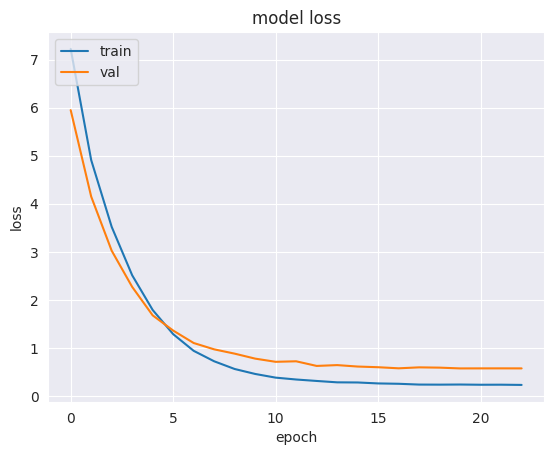

In [35]:
def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_loss()

In [36]:
pred = model.predict(test_gen)

251/251 [==============================] - 80s 304ms/step


In [37]:
pred

array([[0.01493334, 0.05763676, 0.01362271, 0.8884249 , 0.02538238],
       [0.97543395, 0.0103566 , 0.0058732 , 0.00471379, 0.00362253],
       [0.33802742, 0.02489441, 0.02165828, 0.5883702 , 0.02704977],
       ...,
       [0.00448943, 0.00330457, 0.98624736, 0.00388978, 0.00206875],
       [0.03479061, 0.04785069, 0.02958484, 0.6551117 , 0.23266222],
       [0.99275583, 0.00318862, 0.00125266, 0.00169347, 0.00110951]],
      dtype=float32)

In [38]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

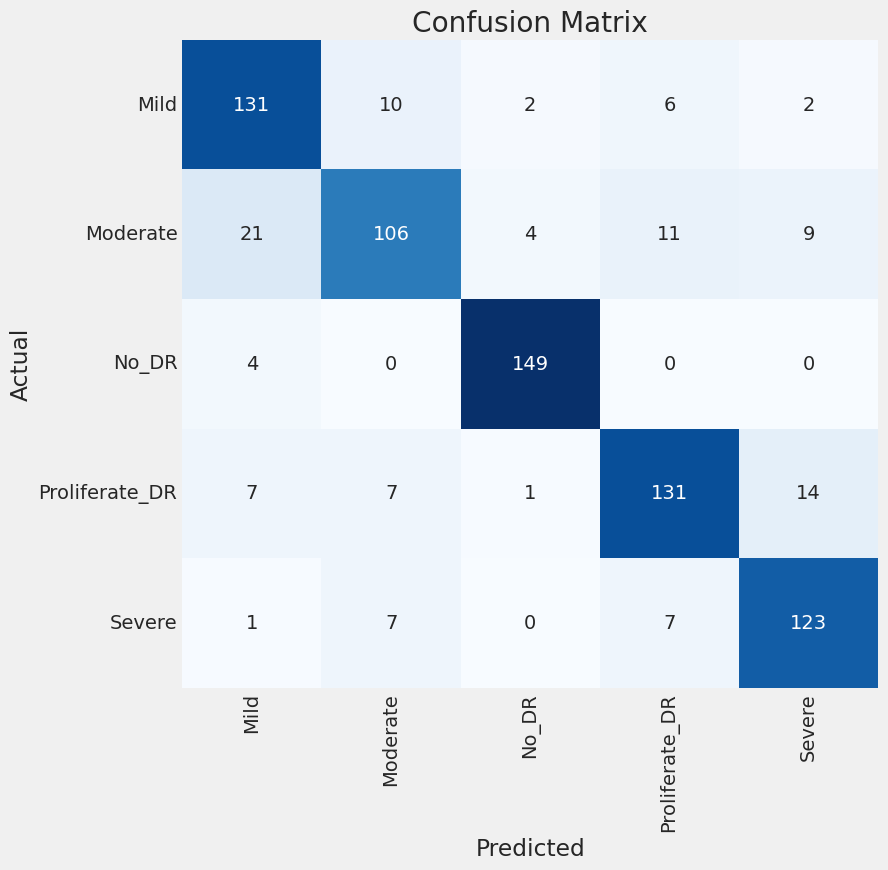

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.80      0.87      0.83       151
      Moderate       0.82      0.70      0.75       151
         No_DR       0.96      0.97      0.96       153
Proliferate_DR       0.85      0.82      0.83       160
        Severe       0.83      0.89      0.86       138

      accuracy                           0.85       753
     macro avg       0.85      0.85      0.85       753
  weighted avg       0.85      0.85      0.85       753



In [39]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, pred, print_code, save_dir, subject )  